In [6]:
# IMPORT PACKAGES/LIBRARIES
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler, TensorDataset
import torchvision.transforms as transforms
from torchvision.transforms import Normalize
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import os
import math
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix,
                             classification_report)
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Data Imports and Preprocess
dir_list = os.listdir(NPY_FILEPATH)
npy_arrays = [np.load(os.path.join(NPY_FILEPATH, each)) for each in dir_list]
alls = np.concatenate(npy_arrays, axis=1)  # alls.shape  (3750, 63600)

alls_df = pd.DataFrame(alls)
labels_sorted = pd.read_csv(LABELS_SORTED_DF)
labels_sorted.drop(columns=['ecg_id'], inplace=True)
labels_sorted.set_index('Unnamed: 0', inplace=True)


ALL_DATA = pd.concat([alls_df, labels_sorted], axis=1)
print(f"ALL_DATA shape: {ALL_DATA.shape}")


X = ALL_DATA.iloc[:, :-1].values  # Features
y = ALL_DATA.iloc[:, -1].values   # Labels

# Splitting & scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Data-augmentation
def augment_data(X):
    noise = np.random.normal(0, 0.1, X.shape)
    return X + noise

X_train_augmented = augment_data(X_train_scaled)

# Class Balancing
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_augmented, y_train)

# Reshaping
X_train = X_train_resampled.reshape(-1, 5300, 12)
X_test = X_test_scaled.reshape(-1, 5300, 12)
y_train = y_train_resampled.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

expected_features = 12 * 5300
X_train_trimmed = X_train_tensor[:, :expected_features]
X_test_trimmed = X_test_tensor[:, :expected_features]
X_train_tensor = X_train_trimmed.view(-1, 12, 5300)
X_test_tensor = X_test_trimmed.view(-1, 12, 5300)

## my model
class ECGCNN(nn.Module):
    def __init__(self):
        super(ECGCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=12, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=5, stride=1, padding=2)

        self.fc1 = nn.Linear(256 * (5300 // 8), 1024)
        self.fc2 = nn.Linear(1024, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool1d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool1d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv3(x))
        x = F.max_pool1d(x, kernel_size=2, stride=2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Init. model
model_cnn = ECGCNN()

#TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

#DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# loss fnc. and opt.
criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy with Logits
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)


ALL_DATA shape: (3750, 63601)


In [7]:

# needed for later plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
auroc_scores = []

## Training loop
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        all_preds = []
        all_labels = []
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            preds = torch.sigmoid(outputs.squeeze()).round().detach()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        train_loss = epoch_loss / len(train_loader)
        train_accuracy = accuracy_score(all_labels, all_preds)
        # AUROC score
        all_preds_proba = torch.sigmoid(torch.tensor(all_preds)).cpu().numpy()
        auroc_score = roc_auc_score(all_labels, all_preds_proba)
        auroc_scores.append(auroc_score)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, AUROC: {auroc_score:.4f}')

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)


In [8]:

## Eval. loop
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)

            preds = torch.sigmoid(outputs.squeeze()).round().detach()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_accuracy = accuracy_score(all_labels, all_preds)
    return test_accuracy


In [10]:

## Model training
train_model(model_cnn, train_loader, criterion, optimizer)


Epoch 1/10, Loss: 0.5882, Accuracy: 0.6773, AUROC: 0.6773
Epoch 2/10, Loss: 0.3240, Accuracy: 0.8542, AUROC: 0.8542
Epoch 3/10, Loss: 0.1284, Accuracy: 0.9549, AUROC: 0.9549
Epoch 4/10, Loss: 0.0588, Accuracy: 0.9800, AUROC: 0.9800
Epoch 5/10, Loss: 0.0479, Accuracy: 0.9875, AUROC: 0.9875
Epoch 6/10, Loss: 0.0562, Accuracy: 0.9833, AUROC: 0.9833
Epoch 7/10, Loss: 0.0143, Accuracy: 0.9947, AUROC: 0.9947
Epoch 8/10, Loss: 0.0092, Accuracy: 0.9985, AUROC: 0.9985
Epoch 9/10, Loss: 0.0487, Accuracy: 0.9879, AUROC: 0.9879
Epoch 10/10, Loss: 0.0317, Accuracy: 0.9917, AUROC: 0.9917


In [11]:

## Evaluating the model
test_accuracy = evaluate_model(model_cnn, test_loader)
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.8640


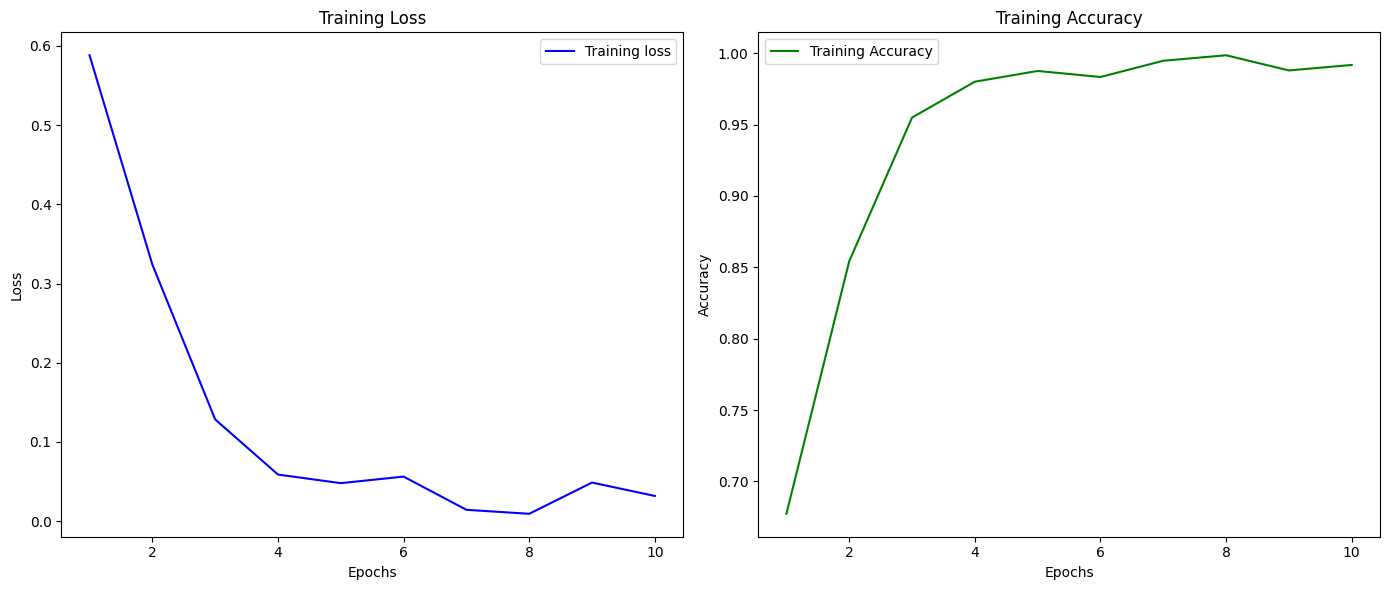

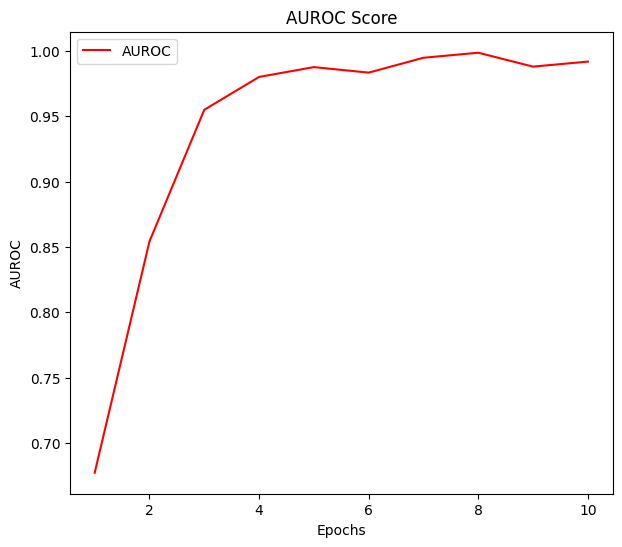

In [12]:
def plot_metrics():
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(14, 6))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'g', label='Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # AUROC Plot
    plt.figure(figsize=(7, 6))
    plt.plot(epochs, auroc_scores, 'r', label='AUROC')
    plt.xlabel('Epochs')
    plt.ylabel('AUROC')
    plt.title('AUROC Score')
    plt.legend()
    plt.show()

plot_metrics()

